##setup

install ananke (note I am using the *stable* branch not the *main* branch---we are in JOSS review and the main branch is frozen till that is finished). the stable branch has some very useful upgrades.

import a couple packages

In [1]:
import numpy as np
import ananke as an
an.__version__

'0.2.0b3'

##example 0: Gaussian "galaxy" blob

We define here some dummy input data. Py-ananke has a method to produce such data.

In [2]:
np.random.seed(0)
p = an.Ananke.make_dummy_particles_input()
p.keys()

dict_keys(['pos3', 'vel3', 'mass', 'age', 'feh', 'helium', 'carbon', 'nitrogen', 'oxygen', 'neon', 'magnesium', 'silicon', 'sulphur', 'calcium', 'alpha', 'parentid', 'partitionid', 'dform', 'id', 'log10_NH'])

The input data must be formatted as a dictionary of equal-length arrays. The dictionary must have the following entries:
- key `pos3`: particle position coordinates in $kpc$ (shape Nx3)
- key `vel3`: particle velocity coordinates in $km.s^{-1}$ (shape Nx3)
- key `mass`: particle stellar mass in solar masses
- key `age`: particle log10 stellar age in years
- key `feh`: particle stellar metallicity \[Fe/H\] in dex relative to solar

Additionally, the following entries can optionally be added:
- key `parentid`: index to give to the parent particle
- key `id`: additional index to classify the parent particle
- key `log10_NH`: log10 hydrogen column densities between Observer position and particle in $cm^{-2}$ - must be provided to estimate extinctions
- key `dform`: particle formation distance
- keys `helium`, `carbon`, `nitrogen`, `oxygen`, `neon`, `magnesium`, `silicon`, `sulphur`, `calcium`: particle various chemical abundances \[X/H\]
- key `alpha`: particle alpha chemical abundances \[Mg/Fe\]

Ananke will compute the phase space densities that are used to determine particle smoothing lengths, but one can include pre-computed densities with the following entries:
- key `rho_pos`: particle density in position space in $kpc^{-3}$
- key `rho_vel`: particle density in velocity space in $km^{-3}.s^{3}$

We can define here some parameters for Ananke such as
 - the observer position `observer`
 - the shell of particles to mask `rshell`
 - the sampling factor `fsample`
 - the photometric system of choise `photo_sys`
 - the CMD `cmd_magnames` and its box limits `cmd_box`

for the photometric system, you can choose from the list generated by this command:

In [3]:
an.display_available_photometric_systems()

{'padova': {'CTIO__DECam': PhotoSystem(category=padova, name=CTIO__DECam),
  'LSST': PhotoSystem(category=padova, name=LSST),
  'GAIA__DR2': PhotoSystem(category=padova, name=GAIA__DR2),
  'Euclid': PhotoSystem(category=padova, name=Euclid),
  'LSST_DP0': PhotoSystem(category=padova, name=LSST_DP0),
  'JWST__MIRI': PhotoSystem(category=padova, name=JWST__MIRI),
  'JWST__NIRCam': PhotoSystem(category=padova, name=JWST__NIRCam),
  'Roman': PhotoSystem(category=padova, name=Roman),
  'APO__SDSS': PhotoSystem(category=padova, name=APO__SDSS),
  'Generic__Johnson_UBVRIJHK': PhotoSystem(category=padova, name=Generic__Johnson_UBVRIJHK),
  'Generic__Stroemgren': PhotoSystem(category=padova, name=Generic__Stroemgren),
  'GAIA__0': PhotoSystem(category=padova, name=GAIA__0),
  'GAIA__0+TYCHO+2MASS': PhotoSystem(category=padova, name=GAIA__0+TYCHO+2MASS),
  'WFIRST': PhotoSystem(category=padova, name=WFIRST),
  'WFIRST+HST__WFC3': PhotoSystem(category=padova, name=WFIRST+HST__WFC3),
  'DCMC': Pho

You can see what the different photometric bands are called by querying the selected system:

In [4]:
ps = an.display_available_photometric_systems()['padova']['GAIA__DR2']
ps.mag_names

['G', 'Gbp', 'Grp']

With this in mind we choose an observer at a random location 50 kpc from the center of the MW -- this is like if we lived in the LMC =)

In [5]:
D = 50 # *units.kpc

#put the observer along a random vector
observer = np.nan*np.ones(3)
while not np.linalg.norm(observer)<1:
    observer = 2*np.random.rand(3)-1

observer *= D/np.linalg.norm(observer)

#select the range in galactocentric radius for which you want to generate particles
rshell = [0, 2*D]

#subsample fraction -- useful for testing before generating a full survey, and for estimating final data volume
fsample = 0.01

#which instrument is surveying ?
photo_sys = 'padova/GAIA__DR2'


#how are you describing the magnitude/color limits of the survey?
#here we're using Gaia G magnitude and BP-RP color
cmd_magnames = {'magnitude': 'G',
                'color_minuend': 'Gbp',
                'color_subtrahend': 'Grp'}

#you can place optional limits in either absolute or apparent magnitude or color
cmd_box = {
           'abs_mag_lim_lo': -1000,
           'abs_mag_lim_hi': 1000,
        #    'app_mag_lim_lo' : -1000,
           'app_mag_lim_hi': 30,
        #    'color_lim_lo' : -1000,
        #    'color_lim_hi' : 1000
           }

For more details regarding these parameters and more, you may consult the docstring associated to the class `Ananke`:

In [6]:
help(an.Ananke)

Help on class Ananke in module ananke.Ananke:

class Ananke(builtins.object)
 |  Ananke(particles: Dict[str, numpy.ndarray[Any, numpy.dtype[+_ScalarType_co]]], name: str, ngb: int = 64, d_params: Dict[str, Any] = {}, e_params: Dict[str, Any] = {}, err_params: Dict[str, Any] = {}, **kwargs: Dict[str, Any]) -> None
 |  
 |  Represents a single ananke pipeline.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, particles: Dict[str, numpy.ndarray[Any, numpy.dtype[+_ScalarType_co]]], name: str, ngb: int = 64, d_params: Dict[str, Any] = {}, e_params: Dict[str, Any] = {}, err_params: Dict[str, Any] = {}, **kwargs: Dict[str, Any]) -> None
 |      Parameters
 |      ----------
 |      particles : dict
 |          A dictionary of same-length arrays representing particles
 |          data of a stellar population - see notes for formatting
 |      
 |      name : str
 |          Name for the pipeline
 |      
 |      ngb : int
 |          Number of neighbours to use in kernel density estimatio

Initialising the survey with the defined quantities above:

In [7]:
name = 'blob'
ananke = an.Ananke(p, name, fsample=fsample,
                   observer=observer, rshell=rshell,
                   photo_sys=photo_sys, cmd_magnames=cmd_magnames,
                   **cmd_box)

/astro/dboyea/.local/lib/python3.9/site-packages/ananke/utils.py:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._record_of_all_used_keys = set()
/astro/dboyea/.local/lib/python3.9/site-packages/ananke/utils.py:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._record_of_all_used_keys = set()


The method `run` runs the pipeline:

In [8]:
survey = ananke.run()

Dimensions = 3
Normalization constant of Kernel type 3: 0.596831
Reading ASCII format file: to_enbid 
Read 300000 records
Allocated 3.8147 MByte for particle storage.
Type = 1 Particles = 100000
Total particles = 100000
Allocated 22.1252 MByte for Binary-Tree and Entropy bins.

Scaling Co-ordinates as x[i]=x[i]/h[i] with h[i]->
1 1 1 

Starting to Build Tree .......
Particle Type = 1 First node number = 1
                  Last node number  = 199999
Total number of nodes = 199999
Treebuild time = 0.176015 s 

Density Calculation. Smoothing .....
Evaluated =   1 % Time Left = 1.099582 s of 1.110700 s Par no = 96805 Density = 4.540411e-02 
Evaluated =   2 % Time Left = 1.074706 s of 1.096650 s Par no = 55454 Density = 4.964532e-03 
Evaluated =   3 % Time Left = 1.136828 s of 1.172000 s Par no = 27717 Density = 1.827217e-01 
Evaluated =   4 % Time Left = 1.149780 s of 1.197700 s Par no = 42234 Density = 2.712376e-02 
Evaluated =   5 % Time Left = 1.134668 s of 1.194400 s Par no = 99785 De

/astro/dboyea/.local/lib/python3.9/site-packages/EnBiD_ananke/__init__.py:237: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  usedvals = pd.read_table(path / CONSTANTS.usedvalues, header=None, delim_whitespace=True,


Dimensions = 3
Normalization constant of Kernel type 3: 0.596831
Reading ASCII format file: to_enbid 
Read 300000 records
Allocated 3.8147 MByte for particle storage.
Type = 1 Particles = 100000
Total particles = 100000
Allocated 22.1252 MByte for Binary-Tree and Entropy bins.

Scaling Co-ordinates as x[i]=x[i]/h[i] with h[i]->
1 1 1 

Starting to Build Tree .......
Particle Type = 1 First node number = 1
                  Last node number  = 199999
Total number of nodes = 199999
Treebuild time = 0.171092 s 

Density Calculation. Smoothing .....
Evaluated =   1 % Time Left = 1.100176 s of 1.111300 s Par no = 3379 Density = 1.586355e-02 
Evaluated =   2 % Time Left = 1.080782 s of 1.102850 s Par no = 75725 Density = 4.756319e-02 
Evaluated =   3 % Time Left = 1.114195 s of 1.148667 s Par no = 95160 Density = 6.928090e-03 
Evaluated =   4 % Time Left = 1.086805 s of 1.132100 s Par no = 40983 Density = 2.235913e-02 
Evaluated =   5 % Time Left = 1.083407 s of 1.140440 s Par no = 79587 Den

/astro/dboyea/.local/lib/python3.9/site-packages/EnBiD_ananke/__init__.py:237: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  usedvals = pd.read_table(path / CONSTANTS.usedvalues, header=None, delim_whitespace=True,


JOB 1/1 | Isochrone Grid Size:                (Age bins=71,Feh bins=34,Alpha bins=1)
JOB 1/1 | Time Isochrone Reading              4.61406     
JOB 1/1 | ------------------------------
JOB 1/1 | nbody1/blob/blob.ebf  Sat No=0
JOB 1/1 | Particles=100000
JOB 1/1 | Satellite Info
JOB 1/1 | Particles=100000 Mass=5.49989e+08 0.379706
JOB 1/1 | Total Stars=5195875 accepted=4025736 rejected=1170139
JOB 1/1 | -----------Done---------------
JOB 1/1 | Total stars written                 4025736                 
JOB 1/1 | 31
JOB 1/1 | File written-                       /arc7/home/dboyea/dwarfs/notebooks/survey.blob.0.ebf
JOB 1/1 | Calculating magnitudes in GAIA__DR2 system................
JOB 1/1 | initializing isochrone data
JOB 1/1 | interpolating on isochrone tables
JOB 1/1 | Appending spherical coordinates................
JOB 1/1 | Total Time=                         14.9286     
Exported the following quantities from /arc7/home/dboyea/dwarfs/notebooks/survey.blob.0.ebf to /arc7/home/dboyea/

/astro/dboyea/.local/lib/python3.9/site-packages/ananke/utils.py:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._record_of_all_used_keys = set()
/astro/dboyea/.local/lib/python3.9/site-packages/ananke/_default_error_model.py:37: RuntimeWarning: overflow encountered in power
  grvs = rpmag + 132.32 - 377.28*ggrp + 402.32*ggrp**2 - 190.97*ggrp**3 + 34.026*ggrp**4
/astro/dboyea/.local/lib/python3.9/site-packages/ananke/_default_error_model.py:37: RuntimeWarning: overflow encountered in multiply
  grvs = rpmag + 132.32 - 377.28*ggrp + 402.32*ggrp**2 - 190.97*ggrp**3 + 34.026*ggrp**4


Exported the following quantities to /arc7/home/dboyea/dwarfs/notebooks/survey.blob.0.h5
['ra_Sig', 'gaia__dr2_grp_Err', 'gaia__dr2_gbp_Sig', 'dec_Err', 'pi_Sig', 'gaia__dr2_grp_Sig', 'gaia__dr2_g_Err', 'mura_Err', 'vr_Err', 'pi_Err', 'vr_Sig', 'mudec_Err', 'dec_Sig', 'gaia__dr2_gbp_Err', 'gaia__dr2_g_Sig', 'mura_Sig', 'mudec_Sig', 'ra_Err']
Overwritten the following quantities to /arc7/home/dboyea/dwarfs/notebooks/survey.blob.0.h5
('ra', 'gaia__dr2_grp', 'pi', 'gaia__dr2_g', 'gaia__dr2_gbp', 'dec', 'mura', 'vr', 'mudec')
Running convert_icrs_to_galactic post-processing pipeline
Overwritten the following quantities to /arc7/home/dboyea/dwarfs/notebooks/survey.blob.0.h5
('glon', 'glat', 'mul', 'mub')


The output is saved as a `vaex` dataframe, with its columns organized in alphabetical order. These notably include:
- key `A_0` for the reference extinction which extinction coefficients are based on (at $\lambda = 550 \, nm$ in the case of Gaia DR2)
- key `A_{filter_name}` for the extinction value in each filter designated by `filter_name` (in this case, where `filter_name` is one of the 3 Gaia bands `gaia_g_bpmag`, `gaia_g_rpmag` \& `gaia_gmag`)
- key `E(B-V)` for the reddening index
- key `age` for the log10 stellar age in years
- key `alpha`, `calcium`, `carbon`, `helium`, `magnesium`, `neon`, `nitrogen`, `oxygen`, `silicon`, `sulphur` for the various chemical abundances as given as input
- key `dec`, `ra` for the astrometric declination and right ascension celestial coordinates in degrees
- key `dform` for the formation distance as given as input
- key `dmod` for the distance modulus
- key `feh` for the stellar metallicity \[Fe/H\] in dex relative to solar
- key `glat`, `glon` for the astrometric galactic latitude and longitude celestrial coordinates in degrees
- key `grav` for the log10 surface gravity in CGS units
- key `log10_NH` for the log10 hydrogen column density between Observer position and star in $cm^{-2}$
- key `lum` for the stellar luminosity in solar luminosities
- key `mact`, `mtip`, `mini` for respectively the current stellar mass, the mass of that same star at tip of giant branch for its given age \& metallicity and its stellar mass on zero-age main sequence, all in solar masses
- key `mub`, `mudec`, `mul`, `mura` for the astrometric proper motions, respectively in the direction of the galactic latitude, declination, galactic longitude and right ascension, all in milliarcseconds per year
- key `parentid` for the parent particle index as given as input
- key `partid` for the flag that identifies stars that are *not* central relatively to their parent particle
- key `pi` for the star parallax in milliarcseconds
- key `px`, `py`, `pz` for the star position cartesian coordinates in $kpc$ relative to the Observer's position
- key `rad` for the star distance to the Observer in $kpc$
- key `teff` for the star effective temperature in Kelvin
- key `vr` for the star astrometric radial velocity in $km.s^{-1}$
- key `vx`, `vy`, `vz` for the star velocity cartesian coordinates in $km.s^{-1}$ relative to the Observer's velocity

Additionally, astrometric and photometric quantities `X` all have associated columns identified as:
- key `X_Sig` for the standard error on the quantity `X`
- key `X_Err` for the actual drawn gaussian error on the quantity `X`

In [9]:
survey

#,A_0,A_gaia__dr2_g,A_gaia__dr2_gbp,A_gaia__dr2_grp,E(B-V),age,alpha,calcium,carbon,dec,dec_Err,dec_Sig,dform,dmod,feh,gaia__dr2_g,gaia__dr2_g_Err,gaia__dr2_g_Intrinsic,gaia__dr2_g_Sig,gaia__dr2_gbp,gaia__dr2_gbp_Err,gaia__dr2_gbp_Intrinsic,gaia__dr2_gbp_Sig,gaia__dr2_grp,gaia__dr2_grp_Err,gaia__dr2_grp_Intrinsic,gaia__dr2_grp_Sig,glat,glon,grav,helium,log10_NH,lum,mact,magnesium,mtip,mub,mudec,mudec_Err,mudec_Sig,mul,mura,mura_Err,mura_Sig,neon,nitrogen,oxygen,parentid,partid,partitionid,pi,pi_Err,pi_Sig,px,py,pz,ra,ra_Err,ra_Sig,rad,satid,silicon,smass,sulphur,teff,vr,vr_Err,vr_Sig,vx,vy,vz
0,0.7093970129666607,0.4813446168726196,0.6919791302820085,0.3930701647178061,0.22883774611827765,10.016325950622559,0.3380742371082306,-1.1830222606658936,-0.39430123567581177,nan,nan,nan,0.0,17.424277601129226,-0.8867433071136475,nan,nan,9.799027,nan,nan,nan,10.739198,nan,nan,nan,8.878314,nan,nan,nan,4.973493,-0.7315406799316406,21.757467670308863,0.0146325985,0.30127868,-0.5486690402030945,0.886202,nan,nan,nan,nan,nan,nan,nan,nan,-0.7326117157936096,-0.652482807636261,-0.6697278618812561,0,0,0,nan,nan,nan,4.182363373262362,20.55564113222749,22.194752018174455,nan,nan,nan,30.53904980334503,0,-0.7563512325286865,0.3020243490121658,-1.0924330949783325,3697.9353,nan,nan,nan,67.38685760498046,-300.3354850769043,55.13861343383789
1,0.3913526151493549,0.26750364609077776,0.38329337281217263,0.2173013047219517,0.12624277908043705,10.016325950622559,0.3380742371082306,-1.1830222606658936,-0.39430123567581177,nan,nan,nan,0.0,17.390715580061478,-0.8867433071136475,nan,nan,9.959197,nan,nan,nan,10.913932,nan,nan,nan,9.031822,nan,nan,nan,4.9897504,-0.7315406799316406,21.499146555104666,0.012805748,0.28124923,-0.5486690402030945,0.886202,nan,nan,nan,nan,nan,nan,nan,nan,-0.7326117157936096,-0.652482807636261,-0.6697278618812561,0,1,0,nan,nan,nan,3.956757589946227,20.765195737939845,21.386817361941056,nan,nan,nan,30.07067078622583,0,-0.7563512325286865,0.2820377126154091,-1.0924330949783325,3670.735,nan,nan,nan,67.7484200428451,-298.29957314526564,52.69162146715175
2,7.392986027528272,4.228226642849086,6.721051834794337,3.742078881938836,2.3848342024284745,10.016325950622559,0.3380742371082306,-1.1830222606658936,-0.39430123567581177,nan,nan,nan,0.0,17.521836330748172,-0.8867433071136475,nan,nan,10.696742,nan,nan,nan,11.735245,nan,nan,nan,9.731261,nan,nan,nan,5.067029,-0.7315406799316406,22.775398200235458,0.0069775437,0.21144438,-0.5486690402030945,0.886202,nan,nan,nan,nan,nan,nan,nan,nan,-0.7326117157936096,-0.652482807636261,-0.6697278618812561,0,1,0,nan,nan,nan,3.290573170028418,21.55564620189174,23.34184778359384,nan,nan,nan,31.94237957511784,0,-0.7563512325286865,0.21238213019025393,-1.0924330949783325,3544.0044,nan,nan,nan,68.03093236871236,-301.4758806839234,56.09200627357448
3,3.6129888513389825,2.152942924578204,3.3984647987110574,1.885880559646144,1.1654802746254782,10.016325950622559,0.3380742371082306,-1.1830222606658936,-0.39430123567581177,nan,nan,nan,0.0,17.515265058866714,-0.8867433071136475,nan,nan,11.371739,nan,nan,nan,12.516027,nan,nan,nan,10.364091,nan,nan,nan,5.1336417,-0.7315406799316406,22.464444936298,0.004074636,0.16601525,-0.5486690402030945,0.886202,nan,nan,nan,nan,nan,nan,nan,nan,-0.7326117157936096,-0.652482807636261,-0.6697278618812561,0,1,0,nan,nan,nan,4.924160588701124,21.9110100582371,22.579176713903795,nan,nan,nan,31.845862217141807,0,-0.7563512325286865,0.1665182820354299,-1.0924330949783325,3419.0562,nan,nan,nan,69.12724120992327,-301.73920387771557,55.1029961513569
4,0.70147951758136,0.5519184618944373,0.723937745582679,0.40898446413249806,0.2262837153488258,10.016325950622559,0.3380742371082306,-1.1830222606658936,-0.39430123567581177,nan,nan,nan,0.0,17.42485571902044,-0.8867433071136475,nan,nan,6.5326443,nan,nan,nan,6.9716687,nan,nan,nan,5.933299,nan,nan,nan,4.679952,-0.7315406799316406,21.752593309473337,0.19784307,0.6136903,-0.5486690402030945,0.886202,nan,nan,nan,nan,nan,nan,nan,nan,-0.7326117157936096,-0.6524

Please refer to [`vaex`'s documentation](https://vaex.io/docs/tutorial.html) for further help on how to use `vaex` dataframes: the following line for example isolate only the rows with non-NaN photometry.

In [10]:
survey[~survey.gaia__dr2_g.isna()]

#,A_0,A_gaia__dr2_g,A_gaia__dr2_gbp,A_gaia__dr2_grp,E(B-V),age,alpha,calcium,carbon,dec,dec_Err,dec_Sig,dform,dmod,feh,gaia__dr2_g,gaia__dr2_g_Err,gaia__dr2_g_Intrinsic,gaia__dr2_g_Sig,gaia__dr2_gbp,gaia__dr2_gbp_Err,gaia__dr2_gbp_Intrinsic,gaia__dr2_gbp_Sig,gaia__dr2_grp,gaia__dr2_grp_Err,gaia__dr2_grp_Intrinsic,gaia__dr2_grp_Sig,glat,glon,grav,helium,log10_NH,lum,mact,magnesium,mtip,mub,mudec,mudec_Err,mudec_Sig,mul,mura,mura_Err,mura_Sig,neon,nitrogen,oxygen,parentid,partid,partitionid,pi,pi_Err,pi_Sig,px,py,pz,ra,ra_Err,ra_Sig,rad,satid,silicon,smass,sulphur,teff,vr,vr_Err,vr_Sig,vx,vy,vz
0,1.1784355432156588,1.0314261135095972,1.2910817788357665,0.7018777186555845,0.38014049781150283,9.608274459838867,0.39980825781822205,-1.1843522787094116,-0.3299902081489563,21.127874,-1.415830159671816e-06,4.774616e-07,0.0,16.80507724815459,-1.2811939716339111,20.852575,-0.004852795110414722,3.020925,0.016184296,21.593903,0.3643776519273297,3.1333654,0.39340872,20.378565,0.06584608983768214,2.8057647,0.39340872,-24.997229,169.63759,4.233621,-0.6864521503448486,21.977884147780994,4.8871756,1.0429796,-0.8813856840133667,1.1263083,1.6371748936449468,0.19818799988490188,1.581499850574395,2.6278286,1.4109320827316632,2.152159952811761,1.1438948560685505,2.6278286,-0.9913690686225891,-0.2547881007194519,-1.2474719285964966,2,1,0,2.4621666000149327,2.418616961912671,1.7188617,-20.471944353607846,3.743422487239838,-9.703280716696693,57.86717,1.383833508851724e-07,4.774616e-07,22.96230332963588,0,-1.176025390625,1.0442555068977784,-0.7581074833869934,7558.504,nan,nan,nan,32.76728474906525,-192.57369431077657,-4.2700470955478504
1,0.10756754161438196,0.08501522821750054,0.11103995533217395,0.0628398751242219,0.034699206972381276,9.308772087097168,-1.2332874536514282,-0.1265670359134674,-0.9339593648910522,54.936115,-8.522349391081431e-08,3.1220146e-08,0.0,17.354159477702417,-0.0037263932172209024,17.923704,0.0008548061586581573,0.48367545,0.0032040053,18.460085,0.010371668839918134,0.98451316,0.039769515,17.26007,0.004233785040490361,-0.16116227,0.039769515,10.921523,156.02429,2.6291623,-0.6207552552223206,20.938259558060768,53.33349,1.7061622,-1.237013816833496,1.6848724,0.5095786916029724,-1.3684848190824896,-0.3063729510799959,0.2418199,1.939277622248958,1.4655092723472265,0.2969923613355817,0.2418199,-0.8466358780860901,-0.1532009094953537,-0.14197787642478943,4,1,0,-0.026181985254901584,-0.06000155704703562,0.11239252,-26.528078652889974,11.797583912217851,5.6022072251246025,81.79531,3.2116634054789246e-08,3.1220146e-08,29.56867715967315,0,-1.3938263654708862,1.7064135489313468,-1.0081976652145386,4824.2783,nan,nan,nan,-22.131924071889497,-223.59604439022843,46.58467247360673
2,0.2028410826289216,0.17779000003196152,0.22146222821196127,0.12136809075976764,0.06543260729965213,9.308772087097168,-1.2332874536514282,-0.1265670359134674,-0.9339593648910522,56.832973,1.7167925597341954e-07,3.845013e-07,0.0,17.347101650730895,-0.0037263932172209024,20.669592,0.017753670371941078,3.1269467,0.014415542,20.177576,-0.7232444789525132,3.3322563,0.33441782,20.425238,0.18045918853594706,2.7763073,0.33441782,13.504885,155.3406,4.185487,-0.6207552552223206,21.213734234690882,4.0640154,1.3335031,-1.237013816833496,1.6848724,2.905144005181665,-1.4710449276136655,-0.35815790522012014,2.1761267,3.3189111069654498,4.1582518986191985,3.011506776674821,2.1761267,-0.8466358780860901,-0.1532009094953537,-0.14197787642478943,4,1,0,0.32702686408011267,0.29309719141315255,1.3842046,-26.04433102566301,11.956702246852599,6.882714934323054,85.142944,2.3655745024409325e-07,3.845013e-07,29.472727597922734,0,-1.3938263654708862,1.3335031605464294,-1.0081976652145386,6604.594,nan,nan,nan,-22.055626585644053,-225.37754752390788,47.58556301665014
3,0.3534349226091244,0.3078742673667805,0.3848620969880451,0.21109066049421735,0.11401126535778205,9.308772087097168,-1.2332874536514282,-0.1265670359134674,-0.9339593648910522,57.446102,8.034828505138149e-07,4.3554536e-07,0.0,17.3582

In [11]:
from matplotlib import pyplot as pl
from matplotlib.colors import LogNorm

select only stars that are not extincted (have an observed magnitude that is not NaN)

In [12]:
survey_observed = survey[~survey.gaia__dr2_g.isna()]


CMD as "observed" by our survey

(21.3, 15.0)

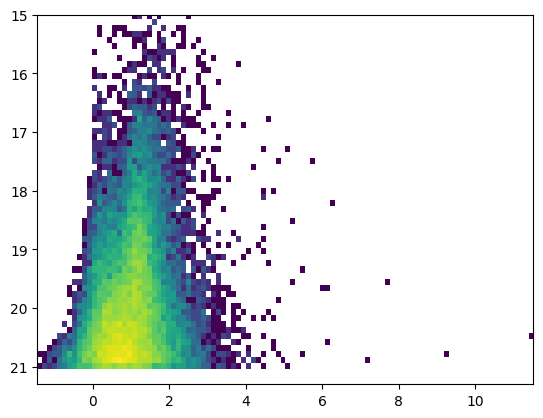

In [13]:
pl.hist2d(survey_observed.gaia__dr2_gbp.values - survey_observed.gaia__dr2_grp.values, survey_observed.gaia__dr2_g.values, bins=100, norm=LogNorm())
pl.ylim(21.3,15)

the "true" CMD -- corrected for distance and extinction/reddening

(10.0, -4.0)

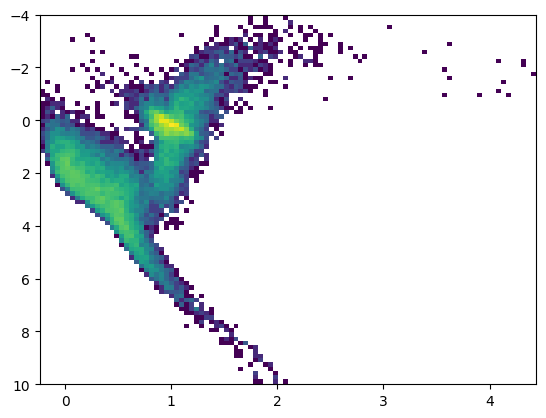

In [14]:
pl.hist2d(survey_observed.gaia__dr2_gbp_Intrinsic.values - survey_observed.gaia__dr2_grp_Intrinsic.values, survey_observed.gaia__dr2_g_Intrinsic.values, bins=100, norm=LogNorm())
pl.ylim(10,-4)

In [15]:
from astropy import coordinates as apc
from astropy import units as u

The code below "wraps" the stars' ra and dec so the main "bulge" is not split across 0<->2π (remember we put ourselves at some random angle so the galaxy center will not be at galactic longitude of zero necessarily)

In [16]:
ra = apc.Angle(survey_observed.ra.values*u.deg).wrap_at(180*u.deg)
dec = apc.Angle(survey_observed.dec.values*u.deg).wrap_at(180*u.deg)

(-90.0, 90.0)

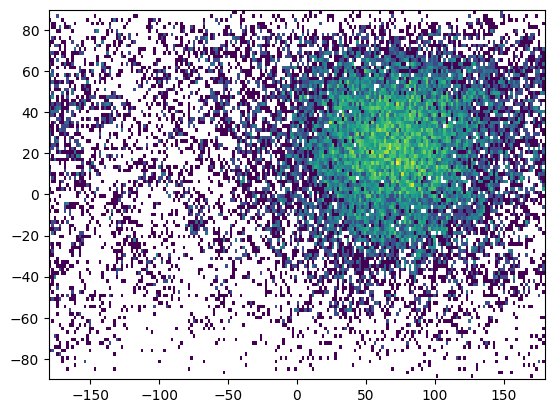

In [17]:
pl.hist2d(ra.value, dec.value, bins=[200,100], norm=LogNorm());

pl.xlim(-180,180)
pl.ylim(-90,90)

##example 1: a stream

In the previous example the galaxy was just a Gaussian blob. Let's do a more complicated example---a stream from the FIRE simulations (see Panithanpaisal et al. 2021)

In [18]:
sample = np.load('example_stream.npz')

The file includes all the things needed to resample, plus a `parentid` to reconnect to the parent simulation that will be passed along

In [19]:
sample.files

['pos3', 'vel3', 'mass', 'age', 'feh', 'parentid']

In [20]:
p={}
for f in sample.files:
    p[f]=sample[f]

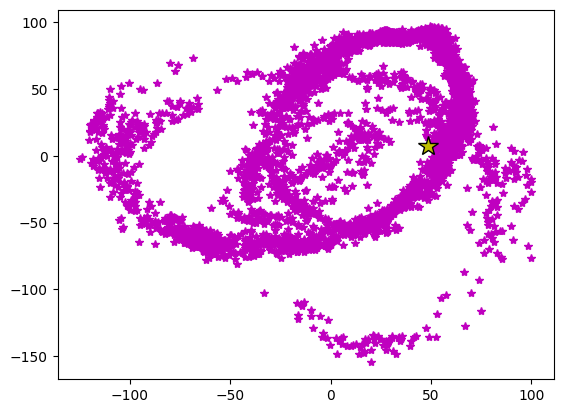

In [21]:
pl.plot(p['pos3'][:,0],p['pos3'][:,2], '*m')
pl.plot(observer[0],observer[2],'*y',ms=15,mec='k')

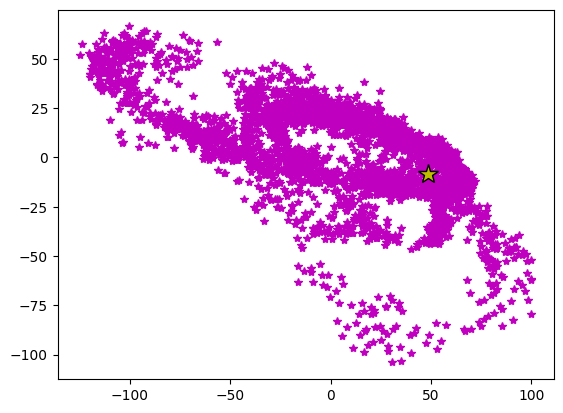

In [22]:
pl.plot(p['pos3'][:,0],p['pos3'][:,1], '*m')
pl.plot(observer[0],observer[1],'*y',ms=15,mec='k')

Let's create a Gaia survey from this new sample as if we were at the Solar circle

In [23]:
observer = [8,0,0] #kpc

In [24]:
name = 'stream'
ananke = an.Ananke(p, name, fsample=fsample,
                   observer=observer, rshell=rshell,
                   photo_sys=photo_sys, cmd_magnames=cmd_magnames,
                   **cmd_box)

/astro/dboyea/.local/lib/python3.9/site-packages/ananke/utils.py:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._record_of_all_used_keys = set()
/astro/dboyea/.local/lib/python3.9/site-packages/ananke/utils.py:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._record_of_all_used_keys = set()


In [25]:
survey = ananke.run()

Dimensions = 3
Normalization constant of Kernel type 3: 0.596831
Reading ASCII format file: to_enbid 
Read 12114 records
Allocated 0.154037 MByte for particle storage.
Type = 1 Particles = 4038
Total particles = 4038
Allocated 0.893417 MByte for Binary-Tree and Entropy bins.

Scaling Co-ordinates as x[i]=x[i]/h[i] with h[i]->
1 1 1 

Starting to Build Tree .......
Particle Type = 1 First node number = 1
                  Last node number  = 8075
Total number of nodes = 8075
Treebuild time = 0.005363 s 

Density Calculation. Smoothing .....
Evaluated =   0 % Time Left = 0.018786 s of 0.018979 s Par no = 786 Density = 1.721369e-04 
Evaluated =   1 % Time Left = 0.023445 s of 0.023925 s Par no = 355 Density = 6.809887e-04 
Evaluated =   2 % Time Left = 0.025036 s of 0.025810 s Par no = 1597 Density = 2.395480e-03 
Evaluated =   3 % Time Left = 0.026485 s of 0.027585 s Par no = 1661 Density = 1.031716e-02 
Evaluated =   4 % Time Left = 0.027166 s of 0.028589 s Par no = 1653 Density = 8.559

/astro/dboyea/.local/lib/python3.9/site-packages/EnBiD_ananke/__init__.py:237: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  usedvals = pd.read_table(path / CONSTANTS.usedvalues, header=None, delim_whitespace=True,
/astro/dboyea/.local/lib/python3.9/site-packages/EnBiD_ananke/__init__.py:237: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  usedvals = pd.read_table(path / CONSTANTS.usedvalues, header=None, delim_whitespace=True,


Executing JOB 1/1 = /arc7/home/dboyea/.local/.cache/Galaxia_ananke/bin/galaxia -r --hdim=6 --nfile=stream --ngen=0 /arc7/home/dboyea/dwarfs/notebooks/survey_params
JOB 1/1 | CODEDATAPATH=/arc7/home/dboyea/.local/.cache/Galaxia_ananke/GalaxiaData/
JOB 1/1 | Reading Parameter file-             /arc7/home/dboyea/dwarfs/notebooks/survey_params
JOB 1/1 | --------------------------------------------------------
JOB 1/1 | outputFile               survey                  
JOB 1/1 | outputDir                /arc7/home/dboyea/dwarfs/notebooks
JOB 1/1 | photoCateg               padova                  
JOB 1/1 | photoSys                 GAIA__DR2               
JOB 1/1 | magcolorNames            G,Gbp-Grp               
JOB 1/1 | appMagLimits[0]          -1000                   
JOB 1/1 | appMagLimits[1]          30                      
JOB 1/1 | absMagLimits[0]          -1000                   
JOB 1/1 | absMagLimits[1]          1000                    
JOB 1/1 | colorLimits[0]           -1000 

/astro/dboyea/.local/lib/python3.9/site-packages/ananke/utils.py:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._record_of_all_used_keys = set()


Exported the following quantities to /arc7/home/dboyea/dwarfs/notebooks/survey.stream.0.h5
['ra_Sig', 'gaia__dr2_grp_Err', 'gaia__dr2_gbp_Sig', 'dec_Err', 'pi_Sig', 'gaia__dr2_grp_Sig', 'gaia__dr2_g_Err', 'mura_Err', 'vr_Err', 'pi_Err', 'vr_Sig', 'mudec_Err', 'dec_Sig', 'gaia__dr2_gbp_Err', 'gaia__dr2_g_Sig', 'mura_Sig', 'mudec_Sig', 'ra_Err']
Overwritten the following quantities to /arc7/home/dboyea/dwarfs/notebooks/survey.stream.0.h5
('ra', 'gaia__dr2_grp', 'pi', 'gaia__dr2_g', 'gaia__dr2_gbp', 'dec', 'mura', 'vr', 'mudec')
Running convert_icrs_to_galactic post-processing pipeline
Overwritten the following quantities to /arc7/home/dboyea/dwarfs/notebooks/survey.stream.0.h5
('glon', 'glat', 'mul', 'mub')


In [26]:
survey.length()

158046

In [27]:
survey_observed = survey[~survey.gaia__dr2_g.isna()]

In [28]:
survey_observed.length()

425

(-90.0, 90.0)

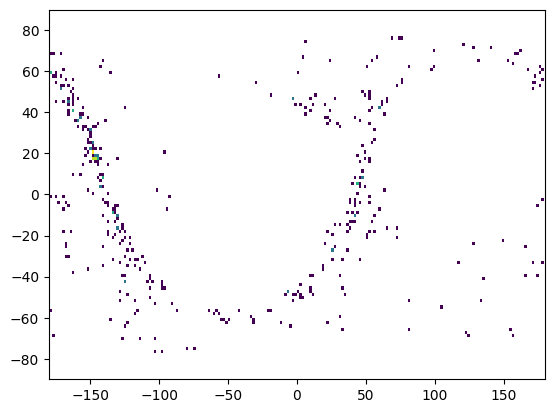

In [29]:
ra = apc.Angle(survey_observed.ra.values*u.deg).wrap_at(180*u.deg)
dec = apc.Angle(survey_observed.dec.values*u.deg).wrap_at(180*u.deg)

pl.hist2d(ra.value, dec.value, bins=[200,100], norm=LogNorm());

pl.xlim(-180,180)
pl.ylim(-90,90)

Here we generated a fraction (1/100th) of the full sample with no magnitude limits, and then selected Gaia observed stars after the fact. Given the results we expect ~40,000 stars from the full survey, which is fairly manageable. Let's now use the inbuilt magnitude limits to generate the full view.

In [30]:
#limits in either absolute or apparent magnitude or color
cmd_box = {
           'abs_mag_lim_lo': -1000,
           'abs_mag_lim_hi': 1000,
        #    'app_mag_lim_lo' : -1000,
           'app_mag_lim_hi': 21.5,
        #    'color_lim_lo' : -1000,
        #    'color_lim_hi' : 1000
           }
fsample = 1.0

In [31]:
ananke = an.Ananke(p, name, fsample=fsample,
                   observer=observer, rshell=rshell,
                   photo_sys=photo_sys, cmd_magnames=cmd_magnames,
                   **cmd_box)

/astro/dboyea/.local/lib/python3.9/site-packages/ananke/utils.py:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._record_of_all_used_keys = set()
/astro/dboyea/.local/lib/python3.9/site-packages/ananke/utils.py:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._record_of_all_used_keys = set()


In [32]:
survey_full = ananke.run()

Dimensions = 3
Normalization constant of Kernel type 3: 0.596831
Reading ASCII format file: to_enbid 
Read 12114 records
Allocated 0.154037 MByte for particle storage.
Type = 1 Particles = 4038
Total particles = 4038
Allocated 0.893417 MByte for Binary-Tree and Entropy bins.

Scaling Co-ordinates as x[i]=x[i]/h[i] with h[i]->
1 1 1 

Starting to Build Tree .......
Particle Type = 1 First node number = 1
                  Last node number  = 8075
Total number of nodes = 8075
Treebuild time = 0.005059 s 

Density Calculation. Smoothing .....
Evaluated =   0 % Time Left = 0.019385 s of 0.019584 s Par no = 786 Density = 1.721369e-04 
Evaluated =   1 % Time Left = 0.021120 s of 0.021553 s Par no = 355 Density = 6.809887e-04 
Evaluated =   2 % Time Left = 0.021511 s of 0.022175 s Par no = 1597 Density = 2.395480e-03 
Evaluated =   3 % Time Left = 0.023044 s of 0.024001 s Par no = 1661 Density = 1.031716e-02 
Evaluated =   4 % Time Left = 0.023578 s of 0.024814 s Par no = 1653 Density = 8.559

/astro/dboyea/.local/lib/python3.9/site-packages/EnBiD_ananke/__init__.py:237: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  usedvals = pd.read_table(path / CONSTANTS.usedvalues, header=None, delim_whitespace=True,
/astro/dboyea/.local/lib/python3.9/site-packages/EnBiD_ananke/__init__.py:237: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  usedvals = pd.read_table(path / CONSTANTS.usedvalues, header=None, delim_whitespace=True,


Executing JOB 1/1 = /arc7/home/dboyea/.local/.cache/Galaxia_ananke/bin/galaxia -r --hdim=6 --nfile=stream --ngen=0 /arc7/home/dboyea/dwarfs/notebooks/survey_params
JOB 1/1 | CODEDATAPATH=/arc7/home/dboyea/.local/.cache/Galaxia_ananke/GalaxiaData/
JOB 1/1 | Reading Parameter file-             /arc7/home/dboyea/dwarfs/notebooks/survey_params
JOB 1/1 | --------------------------------------------------------
JOB 1/1 | outputFile               survey                  
JOB 1/1 | outputDir                /arc7/home/dboyea/dwarfs/notebooks
JOB 1/1 | photoCateg               padova                  
JOB 1/1 | photoSys                 GAIA__DR2               
JOB 1/1 | magcolorNames            G,Gbp-Grp               
JOB 1/1 | appMagLimits[0]          -1000                   
JOB 1/1 | appMagLimits[1]          21.5                    
JOB 1/1 | absMagLimits[0]          -1000                   
JOB 1/1 | absMagLimits[1]          1000                    
JOB 1/1 | colorLimits[0]           -1000 

/astro/dboyea/.local/lib/python3.9/site-packages/ananke/utils.py:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._record_of_all_used_keys = set()


Exported the following quantities to /arc7/home/dboyea/dwarfs/notebooks/survey.stream.0.h5
['ra_Sig', 'gaia__dr2_grp_Err', 'gaia__dr2_gbp_Sig', 'dec_Err', 'pi_Sig', 'gaia__dr2_grp_Sig', 'gaia__dr2_g_Err', 'mura_Err', 'vr_Err', 'pi_Err', 'vr_Sig', 'mudec_Err', 'dec_Sig', 'gaia__dr2_gbp_Err', 'gaia__dr2_g_Sig', 'mura_Sig', 'mudec_Sig', 'ra_Err']
Overwritten the following quantities to /arc7/home/dboyea/dwarfs/notebooks/survey.stream.0.h5
('ra', 'gaia__dr2_grp', 'pi', 'gaia__dr2_g', 'gaia__dr2_gbp', 'dec', 'mura', 'vr', 'mudec')
Running convert_icrs_to_galactic post-processing pipeline
Overwritten the following quantities to /arc7/home/dboyea/dwarfs/notebooks/survey.stream.0.h5
('glon', 'glat', 'mul', 'mub')


In [33]:
survey_full.length()

37440

In [34]:
survey_observed = survey_full[~survey_full.gaia__dr2_g.isna()]

In [35]:
survey_observed.length()

23236

we can recover the spawned particles by choosing those with partid == 0:

In [36]:
survey_parents = survey_full[survey_full.partid==0]

(-90.0, 90.0)

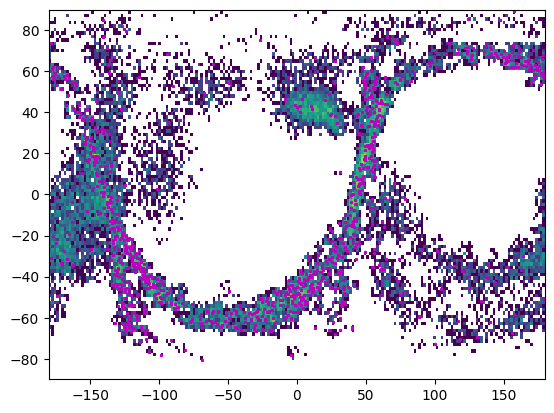

In [37]:
ra = apc.Angle(survey_observed.ra.values*u.deg).wrap_at(180*u.deg)
dec = apc.Angle(survey_observed.dec.values*u.deg).wrap_at(180*u.deg)

pl.hist2d(ra.value, dec.value, bins=[200,100], norm=LogNorm());

ra_parents = apc.Angle(survey_parents.ra.values*u.deg).wrap_at(180*u.deg)
dec_parents = apc.Angle(survey_parents.dec.values*u.deg).wrap_at(180*u.deg)

pl.plot(ra_parents,dec_parents, '*m', ms=2)

pl.xlim(-180,180)
pl.ylim(-90,90)

Here's the proper motion space (axes are mas/yr)

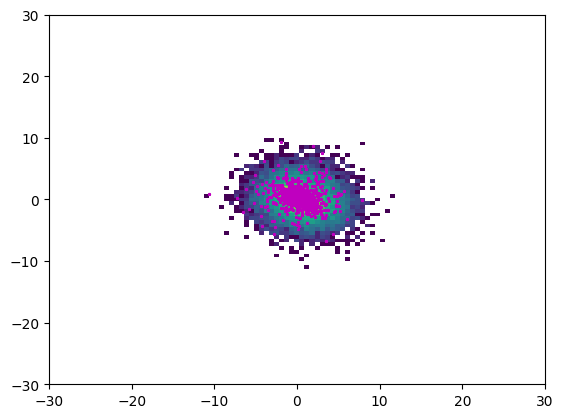

In [38]:
pl.hist2d(survey_observed.mul.values,survey_observed.mub.values,bins=np.linspace(-30,30,100),norm=LogNorm());
pl.plot(survey_parents.mul.values,survey_parents.mub.values,'*m', ms=2);
#pl.xlim(-100,100)
#pl.ylim(-100,100)

Now let's look at the same stream observed with LSST, which has an apparent magnitude limit of 26.9 in g and r over 10 years (\~24.5 in one exposure).

In [39]:
an.display_available_photometric_systems()['padova']['LSST'].mag_names

['u', 'g', 'r', 'i', 'z', 'Y']

In [40]:
cmd_box = {
           'abs_mag_lim_lo': -1000,
           'abs_mag_lim_hi': 1000,
        #    'app_mag_lim_lo' : -1000,
           'app_mag_lim_hi': 26.9,
        #    'color_lim_lo' : -1000,
        #    'color_lim_hi' : 1000
           }

#which instrument is surveying ?
photo_sys = 'padova/LSST'


#how are you describing the magnitude/color limits of the survey?
#here we're using LSST r magnitude and g-r color
cmd_magnames = {'magnitude': 'r',
                'color_minuend': 'g',
                'color_subtrahend': 'r'}

setting up the survey will throw a warning because we haven't implemented the LSST error model yet =)

In [41]:
ananke = an.Ananke(p, name, fsample=fsample,
                   observer=observer, rshell=rshell,
                   photo_sys=photo_sys, cmd_magnames=cmd_magnames,
                   **cmd_box)

/astro/dboyea/.local/lib/python3.9/site-packages/ananke/utils.py:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._record_of_all_used_keys = set()
/astro/dboyea/.local/lib/python3.9/site-packages/ananke/ExtinctionDriver.py:121: UserWarning: Method default_extinction_coeff isn't defined for photometric system padova/LSST
  (ext_coeff(df) if callable(ext_coeff) else ext_coeff)
/astro/dboyea/.local/lib/python3.9/site-packages/astropy/units/quantity.py:1852: RuntimeWarning: Mean of empty slice
  return super().__array_function__(function, types, args, kwargs)
/astro/dboyea/.local/lib/python3.9/site-packages/ananke/utils.py:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._record_of_all_used_keys = set()
/astro/dboyea/.local/lib/python3.9/site-p

In [42]:
survey_lsst = ananke.run()

/astro/dboyea/.local/lib/python3.9/site-packages/EnBiD_ananke/__init__.py:237: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  usedvals = pd.read_table(path / CONSTANTS.usedvalues, header=None, delim_whitespace=True,


Dimensions = 3
Normalization constant of Kernel type 3: 0.596831
Reading ASCII format file: to_enbid 
Read 12114 records
Allocated 0.154037 MByte for particle storage.
Type = 1 Particles = 4038
Total particles = 4038
Allocated 0.893417 MByte for Binary-Tree and Entropy bins.

Scaling Co-ordinates as x[i]=x[i]/h[i] with h[i]->
1 1 1 

Starting to Build Tree .......
Particle Type = 1 First node number = 1
                  Last node number  = 8075
Total number of nodes = 8075
Treebuild time = 0.005105 s 

Density Calculation. Smoothing .....
Evaluated =   0 % Time Left = 0.017587 s of 0.017767 s Par no = 786 Density = 1.721369e-04 
Evaluated =   1 % Time Left = 0.020230 s of 0.020644 s Par no = 355 Density = 6.809887e-04 
Evaluated =   2 % Time Left = 0.021968 s of 0.022646 s Par no = 1597 Density = 2.395480e-03 
Evaluated =   3 % Time Left = 0.023698 s of 0.024682 s Par no = 1661 Density = 1.031716e-02 
Evaluated =   4 % Time Left = 0.023962 s of 0.025217 s Par no = 1653 Density = 8.559

/astro/dboyea/.local/lib/python3.9/site-packages/EnBiD_ananke/__init__.py:237: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  usedvals = pd.read_table(path / CONSTANTS.usedvalues, header=None, delim_whitespace=True,


Executing JOB 1/1 = /arc7/home/dboyea/.local/.cache/Galaxia_ananke/bin/galaxia -r --hdim=6 --nfile=stream --ngen=0 /arc7/home/dboyea/dwarfs/notebooks/survey_params
JOB 1/1 | CODEDATAPATH=/arc7/home/dboyea/.local/.cache/Galaxia_ananke/GalaxiaData/
JOB 1/1 | Reading Parameter file-             /arc7/home/dboyea/dwarfs/notebooks/survey_params
JOB 1/1 | --------------------------------------------------------
JOB 1/1 | outputFile               survey                  
JOB 1/1 | outputDir                /arc7/home/dboyea/dwarfs/notebooks
JOB 1/1 | photoCateg               padova                  
JOB 1/1 | photoSys                 LSST                    
JOB 1/1 | magcolorNames            r,g-r                   
JOB 1/1 | appMagLimits[0]          -1000                   
JOB 1/1 | appMagLimits[1]          26.9                    
JOB 1/1 | absMagLimits[0]          -1000                   
JOB 1/1 | absMagLimits[1]          1000                    
JOB 1/1 | colorLimits[0]           -1000 

/astro/dboyea/.local/lib/python3.9/site-packages/ananke/utils.py:26: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._record_of_all_used_keys = set()
/astro/dboyea/.local/lib/python3.9/site-packages/ananke/ErrorModelDriver.py:77: UserWarning: Method default_error_model isn't defined for photometric system padova/LSST
  return {key: error for error_dict in [(err_model(df) if callable(err_model) else err_model) for err_model in error_model] for key,error in error_dict.items()}  # TODO adapt to dataframe type of output?


Exported the following quantities to /arc7/home/dboyea/dwarfs/notebooks/survey.stream.0.h5
['lsst_g_Err', 'lsst_r_Sig', 'lsst_i_Err', 'lsst_y_Sig', 'lsst_u_Sig', 'lsst_i_Sig', 'lsst_z_Sig', 'lsst_u_Err', 'lsst_y_Err', 'lsst_z_Err', 'lsst_g_Sig', 'lsst_r_Err']
Overwritten the following quantities to /arc7/home/dboyea/dwarfs/notebooks/survey.stream.0.h5
('lsst_i', 'lsst_u', 'lsst_y', 'lsst_r', 'lsst_z', 'lsst_g')
Running convert_icrs_to_galactic post-processing pipeline
Overwritten the following quantities to /arc7/home/dboyea/dwarfs/notebooks/survey.stream.0.h5
('glon', 'glat', 'mul', 'mub')


In [43]:
survey_lsst.length()

4125645

That's right, you just made a 4-million-star mock catalog. Do some plotting! go! =)